In [1]:
!pip install vidaug
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
# import keras_metrics as km
# from keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import math
import vidaug.augmentors as va

In [2]:
data_dir = "/content/drive/MyDrive/video_data"
img_height , img_width = 64, 64
seq_len = 16

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
classes = ["fall_down", "grab", "swallow", "walk","sit","climb","eat"]

In [5]:
def frames_extraction(video_path):
    frames_list = []
     
    vidcap = cv2.VideoCapture(video_path)
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)

    frames_step = total_frames//seq_len
 
    for j in range(seq_len):
        #here, we set the parameter 1 which is the frame number to the frame (i*frames_step)
        vidcap.set(1,j*frames_step)
        success,image = vidcap.read()  
        #save your image
        if success:
          image = cv2.resize(image, (img_height, img_width))
          frames_list.append(image)
        else:
          print("Defected frame {}".format(video_path))
          break
    return frames_list

In [6]:
def create_data(input_dir):
    X = []
    Y = []

    sometimes = lambda aug: va.Sometimes(1, aug) # Used to apply augmentor with 100% probability
    seq = va.Sequential([ # randomly rotates the video with a degree randomly choosen from [-10, 10]  
        sometimes(va.HorizontalFlip()),
    ])

    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
                X.append(seq(frames))

                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [ ]:
import numpy as np
np.save('/content/drive/MyDrive/data/save_X_flip',X)
np.save('/content/drive/MyDrive/data/save_Y_flip',Y)

In [4]:
X_=np.load('/content/drive/MyDrive/data/save_X_triple.npy')
Y_=np.load('/content/drive/MyDrive/data/save_Y_triple.npy')
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.20, shuffle=True, random_state=36)
del X_
del Y_

In [5]:
model = Sequential()

model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = True, input_shape = (seq_len, img_height, img_width, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3),strides = (2,2), return_sequences = True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3),strides = (2,2), return_sequences = True))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))
model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3),strides = (2,2), return_sequences = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('tanh'))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax"))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 16, 31, 31, 32)    40448     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 31, 31, 32)    128       
_________________________________________________________________
activation (Activation)      (None, 16, 31, 31, 32)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 16, 15, 15, 32)    73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 15, 15, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 15, 15, 32)    0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 16, 7, 7, 64)      2

In [6]:
def schedular(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * math.exp(0.1*(10-epoch))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
47/47 [==============================] - 507s 11s/step - loss: 1.9222 - accuracy: 0.2706 - val_loss: 2.0070 - val_accuracy: 0.1528
Epoch 2/50
47/47 [==============================] - 487s 10s/step - loss: 1.6453 - accuracy: 0.3618 - val_loss: 2.2864 - val_accuracy: 0.1613
Epoch 3/50
47/47 [==============================] - 488s 10s/step - loss: 1.4416 - accuracy: 0.4494 - val_loss: 2.0824 - val_accuracy: 0.3063
Epoch 4/50
47/47 [==============================] - 496s 11s/step - loss: 1.2304 - accuracy: 0.5289 - val_loss: 2.5000 - val_accuracy: 0.2307
Epoch 5/50
47/47 [==============================] - 477s 10s/step - loss: 0.9727 - accuracy: 0.6285 - val_loss: 2.6147 - val_accuracy: 0.2876
Epoch 6/50
47/47 [==============================] - 460s 10s/step - loss: 0.7379 - accuracy: 0.7280 - val_loss: 1.9302 - val_accuracy: 0.3687
Epoch 7/50
47/47 [==============================] - 457s 10s/step - loss: 0.5639 - accuracy: 0.7915 - val_loss: 1.5256 - val_accuracy: 0.4731
Epoch 

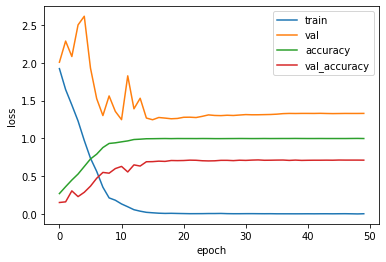

In [7]:
opt = tf.keras.optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks = tf.keras.callbacks.LearningRateScheduler(schedular)
 
history = model.fit(x = X_train, y = y_train, epochs=50, batch_size = 64, shuffle=True, validation_split=0.3, callbacks=callbacks)

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val','accuracy','val_accuracy'])
plt.show()


In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
 
print(classification_report(y_test, y_pred))

print('accuracy score : {}'.format(accuracy_score(y_pred, y_test)))


              precision    recall  f1-score   support

           0       0.68      0.66      0.67       197
           1       0.72      0.71      0.72       146
           2       0.71      0.68      0.69       230
           3       0.64      0.71      0.68       164
           4       0.73      0.79      0.76       145
           5       0.67      0.67      0.67       122
           6       0.79      0.64      0.71        66

    accuracy                           0.70      1070
   macro avg       0.71      0.70      0.70      1070
weighted avg       0.70      0.70      0.70      1070

accuracy score : 0.6981308411214954
